In [18]:
import numpy as np
import models
import metrics
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.stats.diagnostic import acorr_ljungbox

# Carregando os dados

In [19]:
us_change = pd.read_csv('us_change.csv')


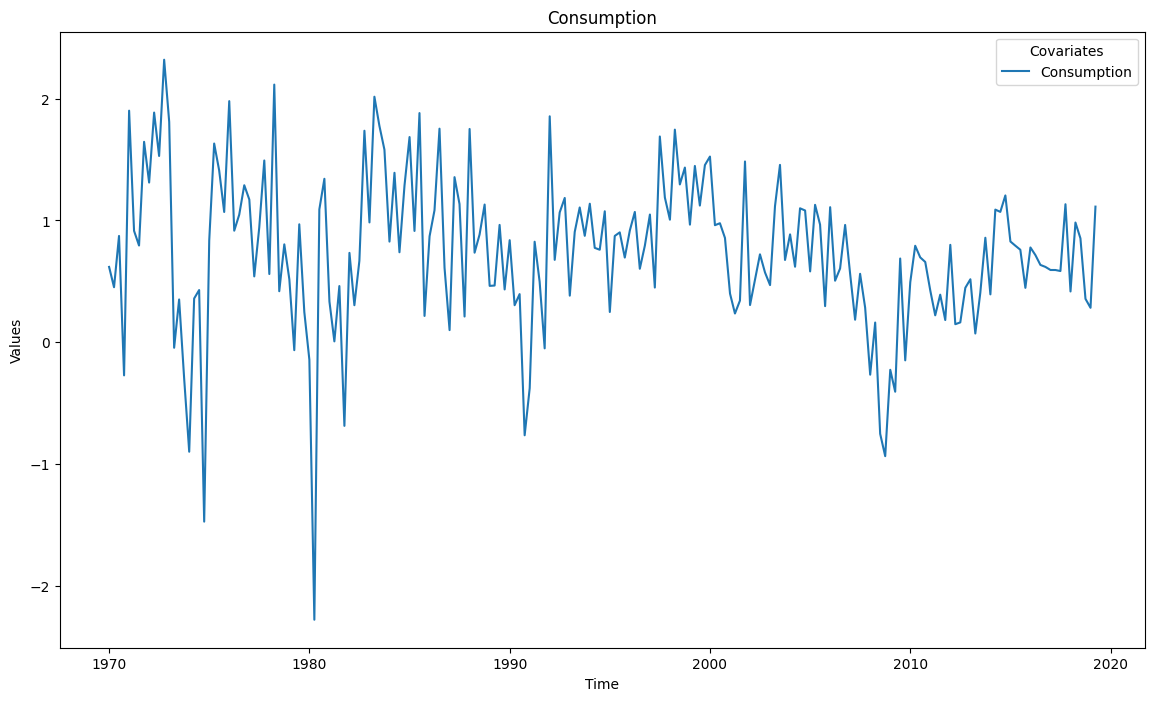

In [20]:
# Convert the 'Quarter' column to datetime format
def parse_quarter(quarter_str):
    year, quarter = quarter_str.split(' ')
    month = (int(quarter[1]) - 1) * 3 + 1
    return pd.Timestamp(f'{year}-{month:02d}-01')

us_change['Quarter'] = us_change['Quarter'].apply(parse_quarter)

# Set the 'Quarter' column as the index
us_change.set_index('Quarter', inplace=True)

# Plot all covariates as time series
plt.figure(figsize=(14, 8))
sns.lineplot(data=us_change['Consumption'], label='Consumption')
plt.title('Consumption')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend(title='Covariates')
plt.show()

In [21]:
us_change['Consumption'][:-12]

Quarter
1970-01-01    0.618566
1970-04-01    0.451984
1970-07-01    0.872872
1970-10-01   -0.271848
1971-01-01    1.901345
                ...   
2015-04-01    0.792813
2015-07-01    0.759427
2015-10-01    0.446824
2016-01-01    0.778254
2016-04-01    0.715591
Name: Consumption, Length: 186, dtype: float64

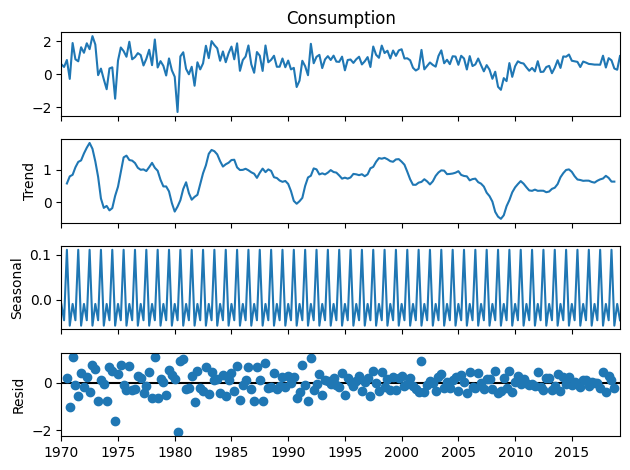

In [22]:
# Decompose the time series
decomposition = seasonal_decompose(us_change['Consumption'], model='additive')
decomposition.plot()
plt.show()

# Modelos baselines

In [23]:
consumption_train = us_change['Consumption'].iloc[:-12]
consumption_test = us_change['Consumption'].iloc[-12:]

naive = models.NaiveModel()
naive.fit(consumption_train)

seasonal_naive = models.SeasonalNaiveModel(4)
seasonal_naive.fit(consumption_train)

average_model = models.AverageModel()
average_model.fit(consumption_train)

drift_model = models.DriftModel()
drift_model.fit(consumption_train)

# Create a DataFrame with the predictions
predictions = pd.DataFrame({
    'Naive': naive.predict(12),
    'Seasonal Naive': seasonal_naive.predict(12),
    'Average': average_model.predict(12),
    'Drift': drift_model.predict(12)
    })

fitted_values = {
    'Naive': [consumption_train[0]],
    'Seasonal Naive': [consumption_train[0]],
    'Average': [consumption_train[0]],
    'Drift': [consumption_train[0]]
}
for i in range(1,len(consumption_train)):
    series = consumption_train[:i]
    naive.fit(series)
    fitted_values['Naive'].append(naive.predict(1)[0])
    
    seasonal_naive.fit(series)
    fitted_values['Seasonal Naive'].append(seasonal_naive.predict(1)[0])
    
    average_model.fit(series)
    fitted_values['Average'].append(average_model.predict(1)[0])
    
    drift_model.fit(series)
    fitted_values['Drift'].append(drift_model.predict(1)[0])
    
fitted_values = pd.DataFrame(fitted_values, index=consumption_train.index)

/home/vinicius/Documents/GitHub/time-series/models.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return np.repeat(self.y_train[-1], n_preds)
/home/vinicius/Documents/GitHub/time-series/models.py:87: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return np.arange(1, n_preds + 1) * (self.y_train[-1] - self.y_train[0]) / len(self.y_train) + self.y_train[-1]
/tmp/ipykernel_21082/818549136.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.il

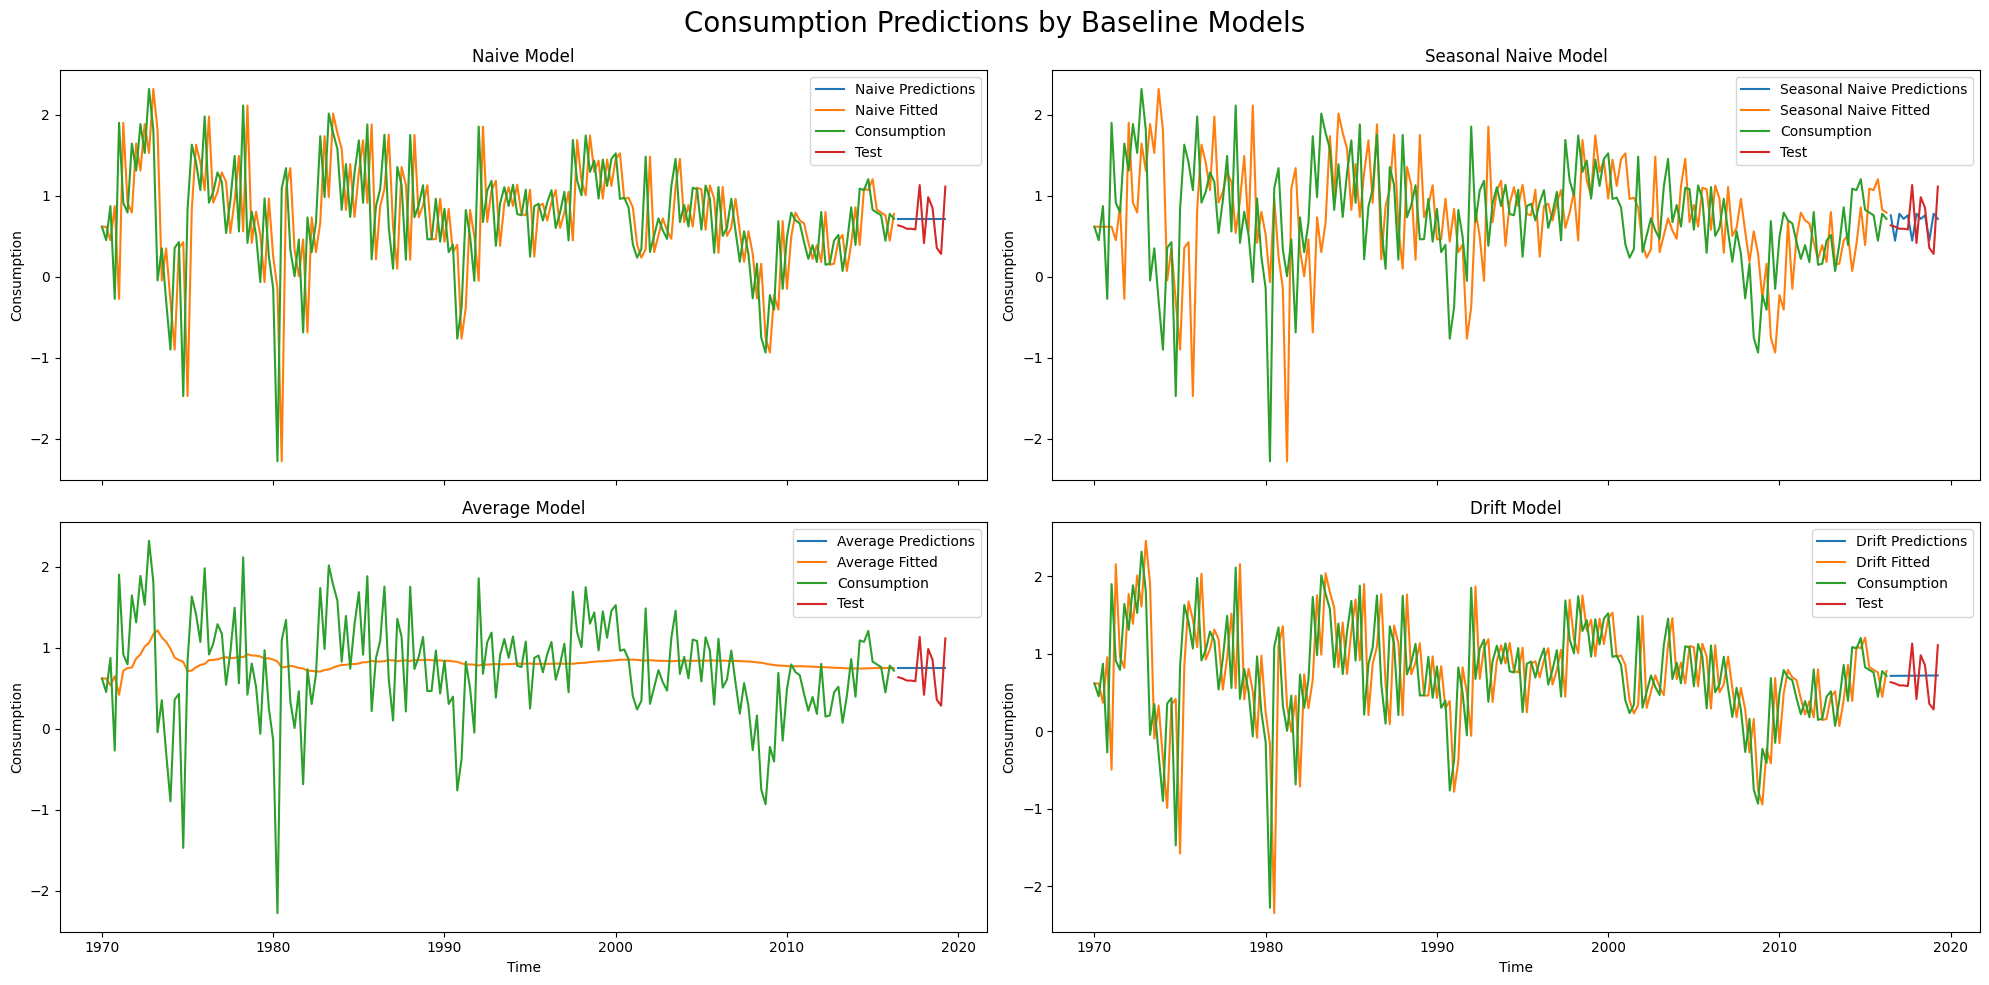

In [24]:
fig, axes = plt.subplots(2, 2, figsize=(20, 10), sharex=True)
fig.suptitle('Consumption Predictions by Baseline Models', fontsize=20)
for ax, model in zip(axes.flatten(), predictions.columns):
    # Create a new series for the predictions
    prediction_series = pd.Series(predictions[model].values, 
                                  index=consumption_test.index)
    
    fitted_series = pd.Series(fitted_values[model].values,
                              index=consumption_train.index)
    
    
    # Plot the prediction series
    sns.lineplot(data=prediction_series, ax=ax, label=f'{model} Predictions')
    
    sns.lineplot(data=fitted_series, ax=ax, label=f'{model} Fitted')
    
    #plot consumption data
    sns.lineplot(data=consumption_train, ax=ax, label='Consumption')
    sns.lineplot(data=consumption_test, ax=ax, label='Test')
    
    ax.set_title(f'{model} Model')
    ax.set_xlabel('Time')
    ax.set_ylabel('Consumption')

plt.tight_layout()
plt.show()

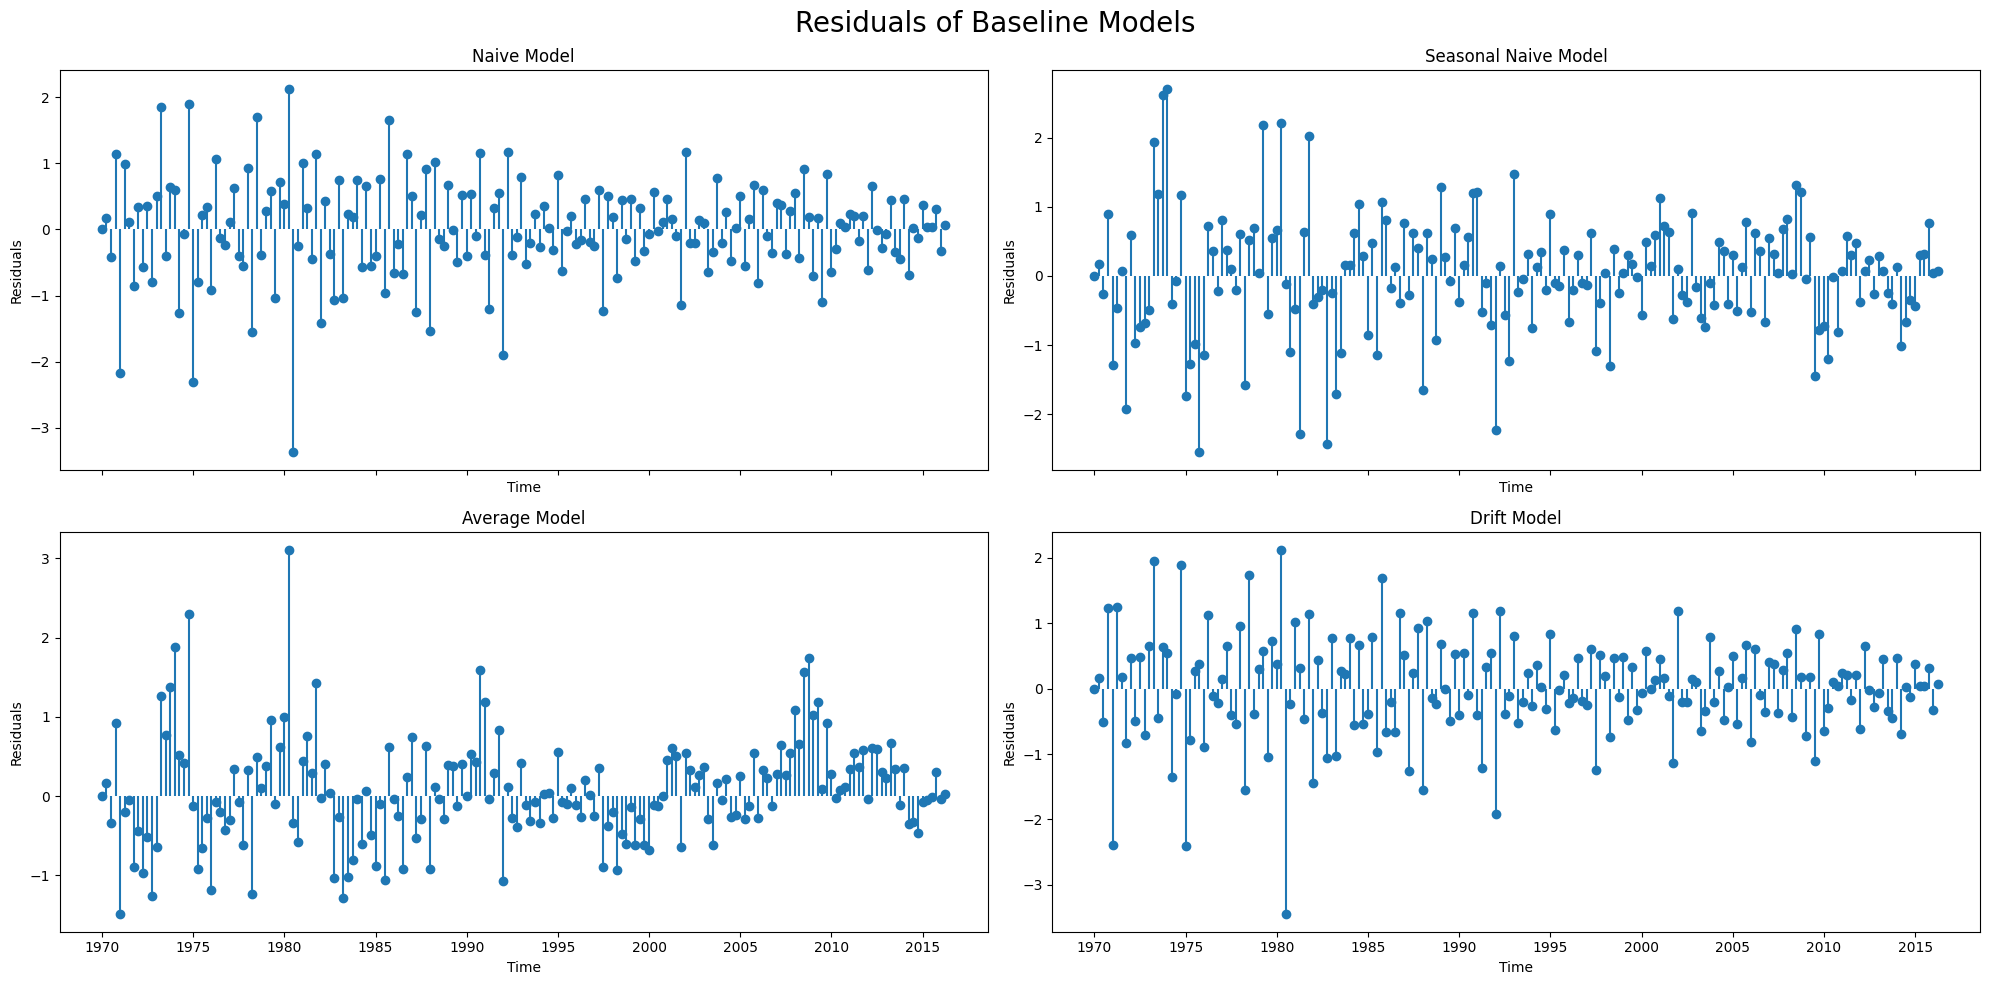

In [25]:
# Calculate residuals for each model
residuals = fitted_values.subtract(consumption_train.values, axis=0)

# Plot residuals as lollipop plots
fig, axes = plt.subplots(2, 2, figsize=(20, 10), sharex=True)
fig.suptitle('Residuals of Baseline Models', fontsize=20)

for ax, model in zip(axes.flatten(), residuals.columns):
    # Create a new series for the residuals
    residual_series = pd.Series(residuals[model].values, index=consumption_train.index)
    
    # Plot the lollipop graph
    ax.stem(residual_series.index, residual_series.values, basefmt=" ")
    
    ax.set_title(f'{model} Model')
    ax.set_xlabel('Time')
    ax.set_ylabel('Residuals')

plt.tight_layout()
plt.show()

In [26]:
ljung_box_results = {}
for model in residuals.columns:
    ljung_box_results[model] = acorr_ljungbox(residuals[model], lags=[10], return_df=True)

# Display the Ljung-Box test results
for model, result in ljung_box_results.items():
    print(f"Ljung-Box Test for {model} Model:")
    print(result)

Ljung-Box Test for Naive Model:
      lb_stat     lb_pvalue
10  57.534498  1.057676e-08
Ljung-Box Test for Seasonal Naive Model:
      lb_stat     lb_pvalue
10  55.586045  2.453937e-08
Ljung-Box Test for Average Model:
      lb_stat     lb_pvalue
10  69.466359  5.620323e-11
Ljung-Box Test for Drift Model:
      lb_stat     lb_pvalue
10  57.623745  1.017573e-08


In [27]:
# Calculate metrics for each model
results = {}
for model in predictions.columns:
    y_pred = fitted_values[model].values
    y_true = consumption_train.values
    results[model] = {
        'MAE': metrics.mae(y_true, y_pred),
        'MSE': metrics.mse(y_true, y_pred),
        'RMSE': metrics.rmse(y_true, y_pred),
        'MAPE': metrics.mape(y_true, y_pred),
        'SMAPE': metrics.smape(y_true, y_pred),
        'R2': metrics.r2(y_true, y_pred)
    }

# Convert results to DataFrame
results_df = pd.DataFrame(results).T
results_df

,MAE,MSE,RMSE,MAPE,SMAPE,R2
Naive,0.565222,0.568697,0.754120,150.857711,76.475564,-0.335116
Seasonal Naive,0.637956,0.730952,0.854957,314.323472,80.619960,-0.716038
Average,0.485630,0.441365,0.664353,177.980105,62.230199,-0.036183
Drift,0.575088,0.592546,0.769770,152.853326,76.891494,-0.391106


In [28]:
# Calculate metrics for each model
results = {}
for model in predictions.columns:
    y_pred = predictions[model].values
    y_true = consumption_test.values
    results[model] = {
        'MAE': metrics.mae(y_true, y_pred),
        'MSE': metrics.mse(y_true, y_pred),
        'RMSE': metrics.rmse(y_true, y_pred),
        'MAPE': metrics.mape(y_true, y_pred),
        'SMAPE': metrics.smape(y_true, y_pred),
        'R2': metrics.r2(y_true, y_pred)
    }

# Convert results to DataFrame
results_df = pd.DataFrame(results).T
results_df

,MAE,MSE,RMSE,MAPE,SMAPE,R2
Naive,0.238689,0.074294,0.272570,44.437127,35.677297,-0.017017
Seasonal Naive,0.264231,0.101543,0.318657,45.887725,39.298513,-0.390018
Average,0.248989,0.077428,0.278259,47.795364,36.974685,-0.059915
Drift,0.239037,0.074445,0.272847,44.759343,35.709487,-0.019084


# Modelos de Suavização exponencial

In [29]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing

# Fit the models
ses = SimpleExpSmoothing(consumption_train)
ses = ses.fit()

holt = Holt(consumption_train)
holt = holt.fit()

damped_model = Holt(consumption_train, damped_trend=True)
damped_model = damped_model.fit()

holts_winter = ExponentialSmoothing(consumption_train, seasonal='add', seasonal_periods=4)
holts_winter = holts_winter.fit()

# Create a DataFrame with the predictions
predictions_exp = pd.DataFrame({
    'SES': ses.forecast(12),
    'Holt': holt.forecast(12),
    'Damped': damped_model.forecast(12),
    'Holts-Winter': holts_winter.forecast(12)
    })

fitted_values = pd.DataFrame({
    'SES': ses.fittedvalues,
    'Holt': holt.fittedvalues,
    'Damped': damped_model.fittedvalues,
    'Holts-Winter': holts_winter.fittedvalues
})

/home/vinicius/.cache/pypoetry/virtualenvs/time-series-k5k_yuzR-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/home/vinicius/.cache/pypoetry/virtualenvs/time-series-k5k_yuzR-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/home/vinicius/.cache/pypoetry/virtualenvs/time-series-k5k_yuzR-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/home/vinicius/.cache/pypoetry/virtualenvs/time-series-k5k_yuzR-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so infe

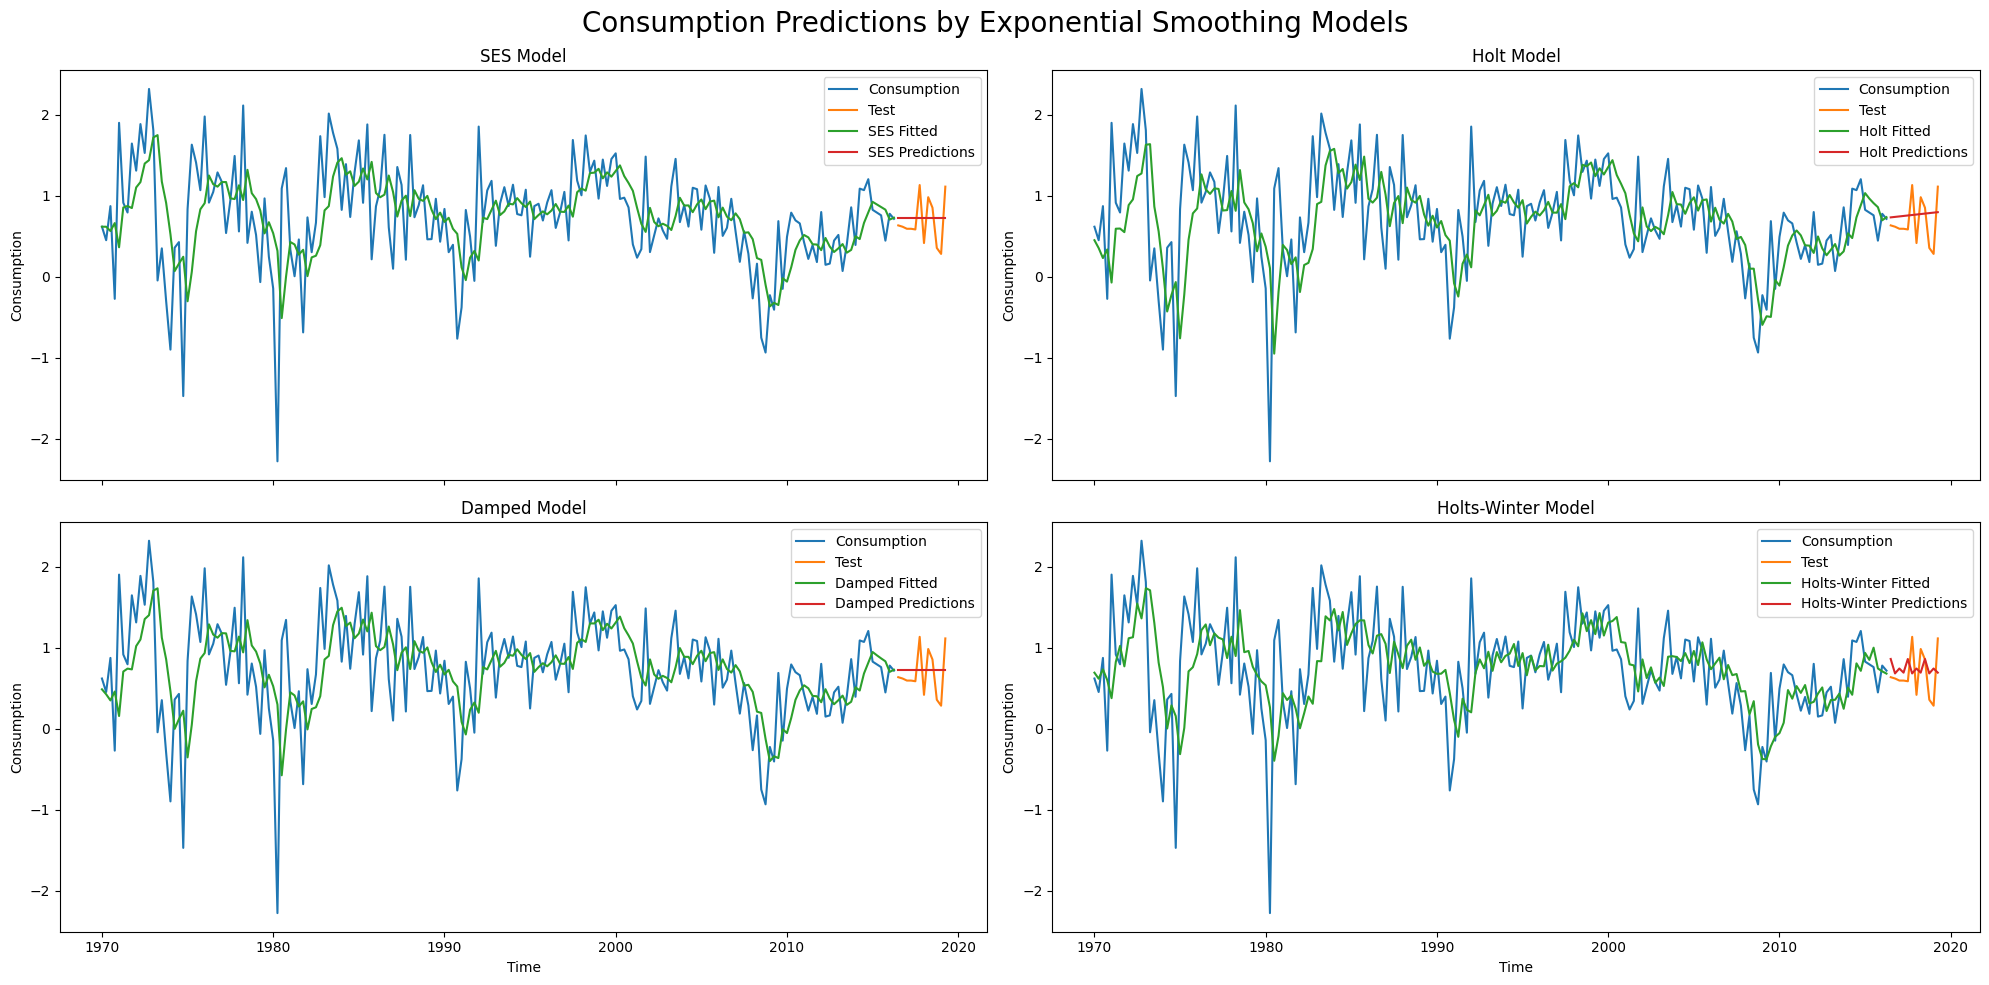

In [30]:
# Plot the predictions and the actual consumption data
fig, axes = plt.subplots(2, 2, figsize=(20, 10), sharex=True)
fig.suptitle('Consumption Predictions by Exponential Smoothing Models', fontsize=20)
for ax, model in zip(axes.flatten(), predictions_exp.columns):
    # Create a new series for the predictions
    prediction_series = pd.Series(predictions_exp[model].values, 
                                  index=pd.date_range(start=consumption_train.index[-1], periods=12, freq='QE'))
    
    # Plot consumption data
    sns.lineplot(data=consumption_train, ax=ax, label='Consumption')
    sns.lineplot(data=consumption_test, ax=ax, label='Test')
    
        # Plot the fitted values on the training data
    sns.lineplot(data=fitted_values[model], ax=ax, label=f'{model} Fitted')
    
    # Plot the prediction series
    sns.lineplot(data=prediction_series, ax=ax, label=f'{model} Predictions')
    
    ax.set_title(f'{model} Model')
    ax.set_xlabel('Time')
    ax.set_ylabel('Consumption')

plt.tight_layout()
plt.show()

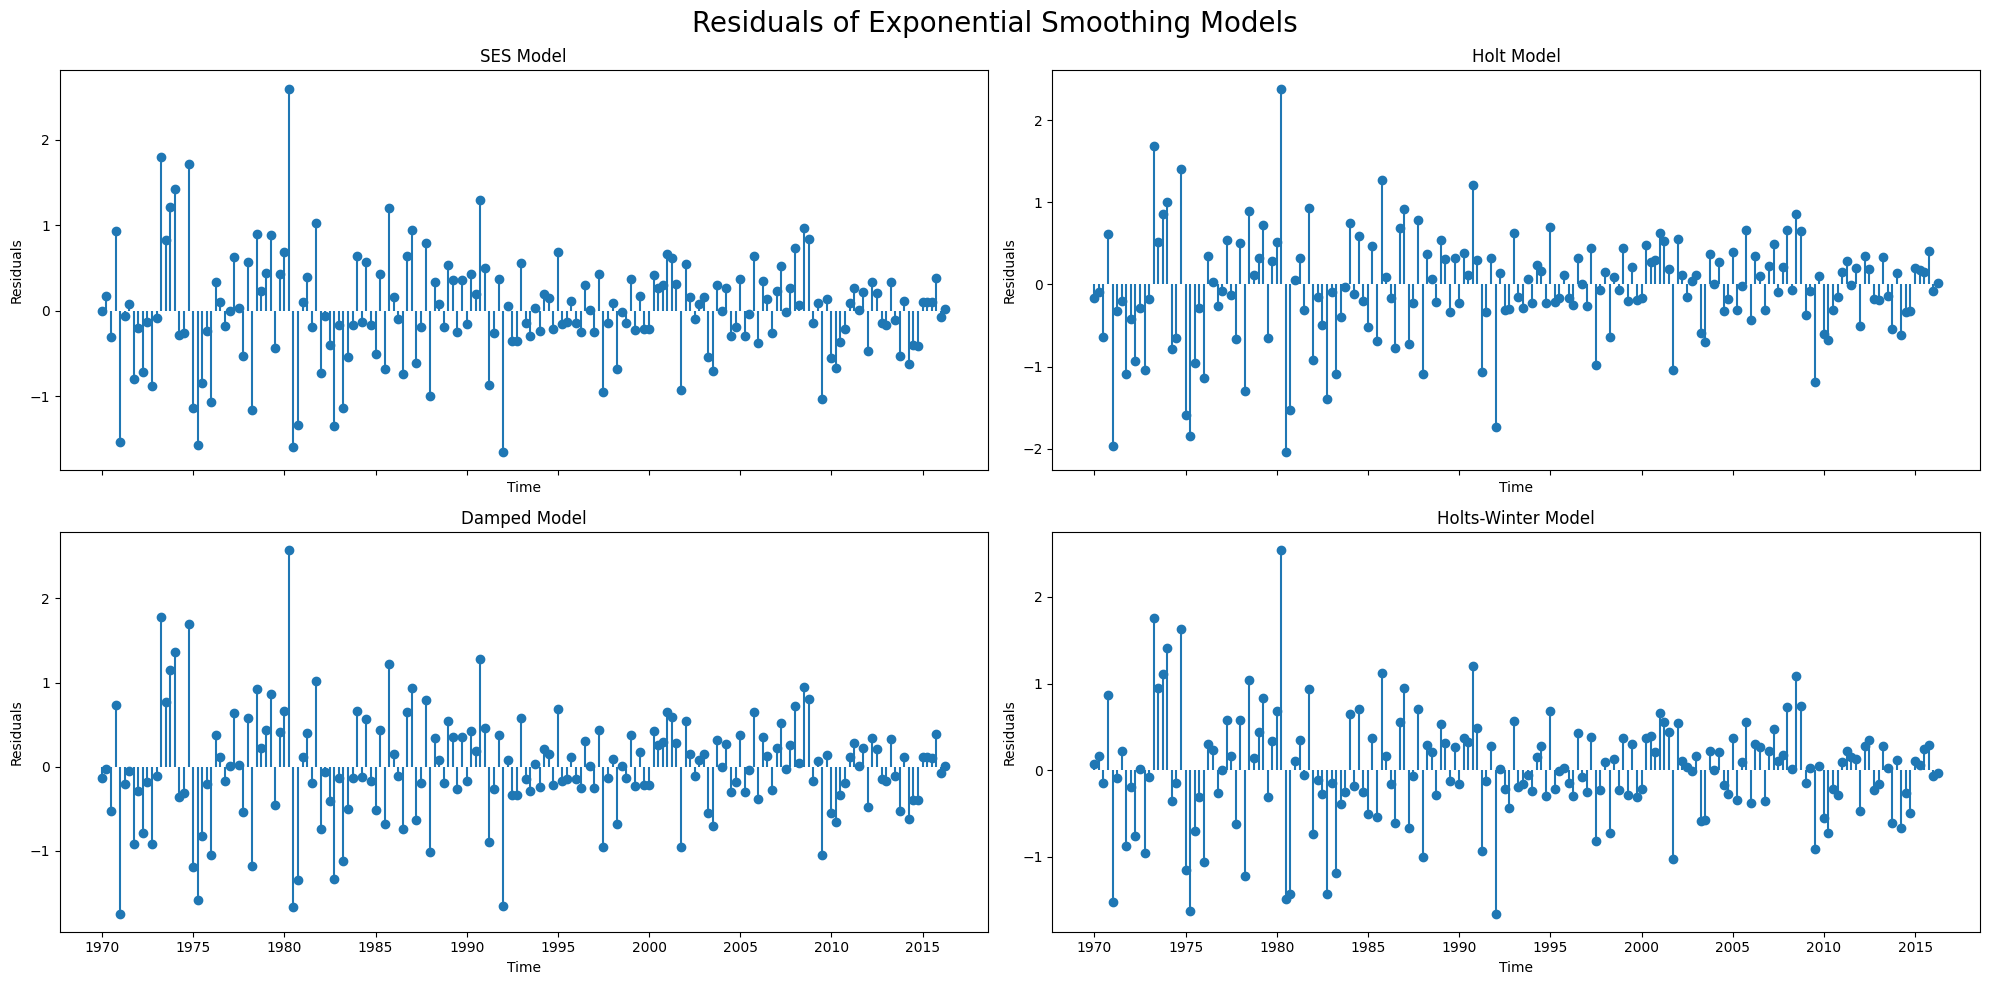

In [31]:

residuals = fitted_values.subtract(consumption_train.values, axis=0)

fig, axes = plt.subplots(2, 2, figsize=(20, 10), sharex=True)
fig.suptitle('Residuals of Exponential Smoothing Models', fontsize=20)

for ax, model in zip(axes.flatten(), residuals.columns):
    residual_series = pd.Series(residuals[model].values, index=consumption_train.index)

    ax.stem(residual_series.index, residual_series.values, basefmt=" ")
    
    ax.set_title(f'{model} Model')
    ax.set_xlabel('Time')
    ax.set_ylabel('Residuals')

plt.tight_layout()
plt.show()

In [32]:
ljung_box_results = {}
for model in residuals.columns:
    ljung_box_results[model] = acorr_ljungbox(residuals[model], lags=[10], return_df=True)

# Display the Ljung-Box test results
for model, result in ljung_box_results.items():
    print(f"Ljung-Box Test for {model} Model:")
    print(result)

Ljung-Box Test for SES Model:
      lb_stat  lb_pvalue
10  17.481703   0.064362
Ljung-Box Test for Holt Model:
      lb_stat  lb_pvalue
10  13.975021   0.174134
Ljung-Box Test for Damped Model:
      lb_stat  lb_pvalue
10  16.685397   0.081622
Ljung-Box Test for Holts-Winter Model:
      lb_stat  lb_pvalue
10  19.897507   0.030237


In [33]:
# Calculate metrics for each model
results = {}
for model in predictions_exp.columns:
    y_pred = fitted_values[model].values
    y_true = consumption_train.values
    results[model] = {
        'MAE': metrics.mae(y_true, y_pred),
        'MSE': metrics.mse(y_true, y_pred),
        'RMSE': metrics.rmse(y_true, y_pred),
        'MAPE': metrics.mape(y_true, y_pred),
        'SMAPE': metrics.smape(y_true, y_pred),
        'R2': metrics.r2(y_true, y_pred)
    }

# Convert results to DataFrame
results_df = pd.DataFrame(results).T
results_df

,MAE,MSE,RMSE,MAPE,SMAPE,R2
SES,0.454804,0.384098,0.619757,136.508431,66.461330,0.098262
Holt,0.475107,0.413237,0.642835,128.926467,70.133179,0.029854
Damped,0.458823,0.388341,0.623170,136.922388,67.713299,0.088300
Holts-Winter,0.451481,0.377026,0.614024,129.106557,65.497252,0.114865


In [34]:
# Calculate metrics for each model
results = {}
for model in predictions_exp.columns:
    y_pred = predictions_exp[model].values
    y_true = consumption_test.values
    results[model] = {
        'MAE': metrics.mae(y_true, y_pred),
        'MSE': metrics.mse(y_true, y_pred),
        'RMSE': metrics.rmse(y_true, y_pred),
        'MAPE': metrics.mape(y_true, y_pred),
        'SMAPE': metrics.smape(y_true, y_pred)
    }

# Convert results to DataFrame
results_df = pd.DataFrame(results).T
results_df

,MAE,MSE,RMSE,MAPE,SMAPE
SES,0.241909,0.075069,0.273987,45.486762,36.091953
Holt,0.246760,0.079665,0.282249,49.409296,36.524365
Damped,0.241174,0.074876,0.273634,45.247293,35.998100
Holts-Winter,0.257578,0.087646,0.296050,47.812952,37.989660
